In [1]:
from google.colab import files

# Upload your Kaggle API key (kaggle.json) file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
import kaggle

# Download and unzip the dataset
kaggle.api.dataset_download_files('prithwirajmitra/covid-face-mask-detection-dataset', path='.', unzip=True)

In [4]:
import os

# List the files in the current directory
extracted_files = os.listdir('.')
print("Extracted Files:", extracted_files)

Extracted Files: ['.config', 'New Masks Dataset', 'sample_data']


In [5]:
import os
import cv2
import numpy as np
import random
import keras

from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

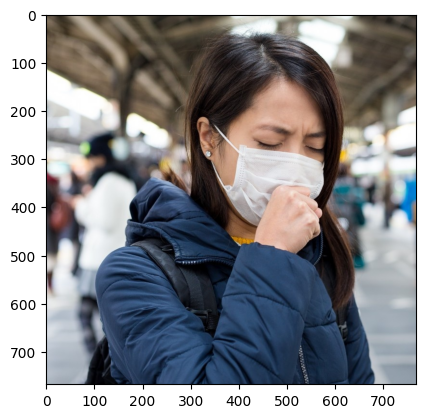

In [6]:
images_withMask = os.listdir("/content/New Masks Dataset/Train/Mask")
sample_img_withMask = random.choice(images_withMask)
image = load_img("/content/New Masks Dataset/Train/Mask/"+sample_img_withMask)
plt.imshow(image)

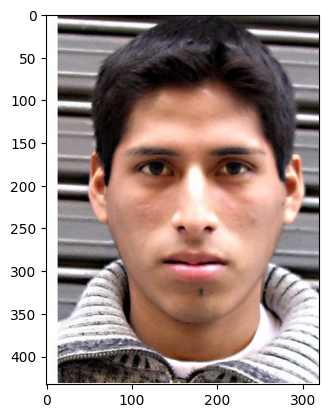

In [7]:
images_withoutMask = os.listdir("/content/New Masks Dataset/Train/Non Mask")
sample_img_withoutMask = random.choice(images_withoutMask)
image = load_img("/content/New Masks Dataset/Train/Non Mask/"+sample_img_withoutMask)
plt.imshow(image)

In [8]:
# define constant
img_width=224
img_height=224

# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 50
BS = 32
train_data_dir="/content/New Masks Dataset/Train"
test_data_dir="/content/New Masks Dataset/Validation"

In [9]:
all_train_imagePaths = list(paths.list_images(train_data_dir))
all_test_imagePaths = list(paths.list_images(test_data_dir))
train_data = []
train_labels = []
test_data = []
test_labels = []

In [10]:
# loop over the image paths
for imagePath in all_train_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	train_data.append(image)
	train_labels.append(label)

In [11]:
# loop over the image paths
for imagePath in all_test_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))

	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	test_data.append(image)
	test_labels.append(label)

In [12]:
def convert_data_labels(data,labels):
  # convert the data and labels to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)

  # perform one-hot encoding on the labels
  lb = LabelBinarizer()
  labels = lb.fit_transform(labels)
  labels = to_categorical(labels)
  return  data,labels

In [13]:
train_data,train_labels = convert_data_labels(train_data,train_labels)
test_data,test_labels = convert_data_labels(test_data,test_labels)

In [14]:
print("Size of train dataset : ",train_data.shape[0])
print("Size of test dataset : ",test_data.shape[0])

Size of train dataset :  600
Size of test dataset :  306


In [15]:
# train datagen
train_datagen = ImageDataGenerator(
                  rotation_range=20,
                  zoom_range=0.15,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.15,
                  horizontal_flip=True,
                  fill_mode="nearest")

train_generator = train_datagen.flow(train_data, train_labels, batch_size=BS)

# **Model Building**

In [16]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
# construct the head of the model that will be placed on top of the the base model
headModel = mobilenet.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [18]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=mobilenet.input, outputs=headModel)

In [19]:
# Import the legacy Adam optimizer
from tensorflow.keras.optimizers import Adam as AdamLegacy

# Compile your model using the legacy optimizer
print("[INFO] compiling model...")
opt = AdamLegacy(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
print("Done !!")

[INFO] compiling model...
Done !!


In [20]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in mobilenet.layers:
	layer.trainable = False

In [21]:
# this code is to show how much time required to train the model using different algorithms
from datetime import datetime
def timer(start_time= None):
  if not start_time:
    start_time=datetime.now()
    return start_time
  elif start_time:
    thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
    tmin,tsec=divmod(temp_sec,60)
    print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

In [23]:
# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

# ModelCheckPoint
checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/fmd_model.h5",
                             monitor='val_loss',
                             mode='auto',
                             save_best_only=True,
                             verbose=1)

# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [24]:
callbacks = [earlystop , checkPoint, learning_rate_reduction]

In [25]:
start_time=timer(None)
classifier = model.fit(
    train_datagen.flow(train_data, train_labels, batch_size=BS),
    epochs=EPOCHS,
    validation_data=(test_data,test_labels),
    validation_steps=len(test_data)//BS,
    steps_per_epoch=len(train_data)//BS,
    callbacks=callbacks
)
timer(start_time)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8415
Epoch 1: val_loss improved from inf to 0.44153, saving model to /content/fmd_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 43s 667ms/step - loss: 0.4152 - accuracy: 0.8415 - val_loss: 0.4415 - val_accuracy: 0.7549 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9806
Epoch 2: val_loss did not improve from 0.44153
18/18 [==============================] - 8s 438ms/step - loss: 0.1107 - accuracy: 0.9806 - val_loss: 0.4720 - val_accuracy: 0.8072 - lr: 1.0000e-04
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9930
Epoch 3: val_loss improved from 0.44153 to 0.35401, saving model to /content/fmd_model.h5
18/18 [==============================] - 9s 496ms/step - loss: 0.0481 - accuracy: 0.9930 - val_loss: 0.3540 - val_accuracy: 0.8627 - lr: 1.0000e-04
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9931
Epoch 4: val_loss improved from 0.35401 to 0.30201, saving model to /content/fmd_model.h5
18/18 [==============================] - 9s 50

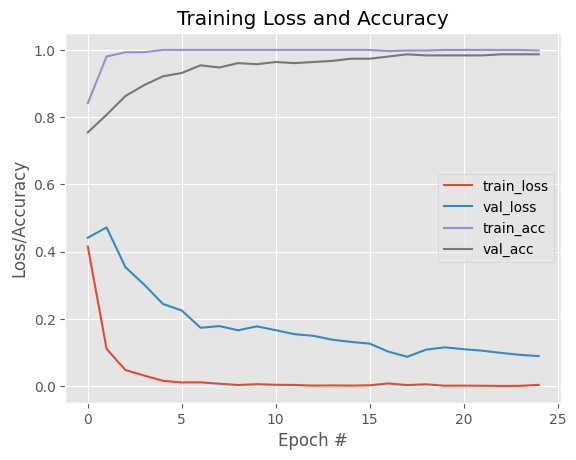

In [26]:
# plot the training loss and accuracy
plt.style.use("ggplot")
N = 10 # epochs number
plt.figure()
plt.plot( classifier.history["loss"], label="train_loss")
plt.plot( classifier.history["val_loss"], label="val_loss")
plt.plot( classifier.history["accuracy"], label="train_acc")
plt.plot( classifier.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CV_Model")

In [27]:
# make predictions on the testing set
print("evaluating network")
predIdxs = model.predict(test_data, batch_size=BS)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# check accuracy
val_loss,val_acc = model.evaluate(test_data,test_labels)
print("Accuracy : ",val_acc)
print("Loss : ",val_loss)

evaluating network
10/10 [==============================] - 2s 46ms/step - loss: 0.0874 - accuracy: 0.9869
Accuracy :  0.9869281053543091
Loss :  0.08738183975219727


In [28]:
print(classification_report(test_labels.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       153
           1       0.97      1.00      0.99       153

    accuracy                           0.99       306
   macro avg       0.99      0.99      0.99       306
weighted avg       0.99      0.99      0.99       306



1/1 [==============================] - 1s 764ms/step
The person in the image is not wearing a mask.


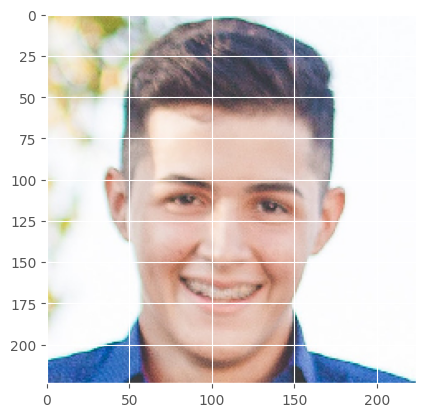

In [37]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

def predict_mask(image_path, model_path='/content/drive/MyDrive/cv-project/fmd_model.h5', threshold=0.5):
    # Load the pre-trained model
    model = load_model(model_path)

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Make prediction
    prediction = model.predict(img_array)

    # Interpret the result
    if prediction[0][0] > threshold:
        return "The person in the image is wearing a mask."
    else:
        return "The person in the image is not wearing a mask."

# Example
img_path = '/content/drive/MyDrive/cv-project/real_01072.jpg'
result = predict_mask(img_path)
print(result)

1/1 [==============================] - 1s 762ms/step
The person in the image is wearing a mask.


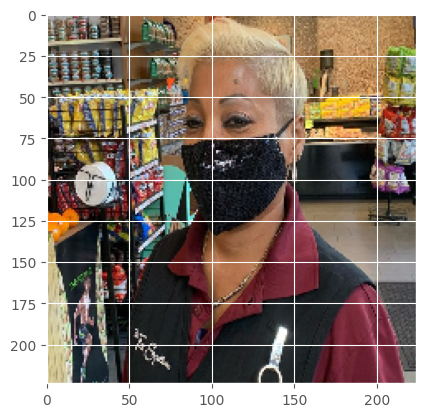

In [38]:
result = predict_mask('/content/drive/MyDrive/cv-project/2225.png')
print(result)